In [56]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

### Load data

In [57]:
def parser(timestamps):
    result = []
    for timestamp in timestamps:
        parsed_date = to_datetime(timestamp, format='%Y-%m-%d')
        result.append(parsed_date)
    return result

timestamp
2016-06-24    500.00
2016-06-25    499.01
2016-06-26    499.00
2016-06-27    463.02
2016-06-28    480.00
Name: close, dtype: float64


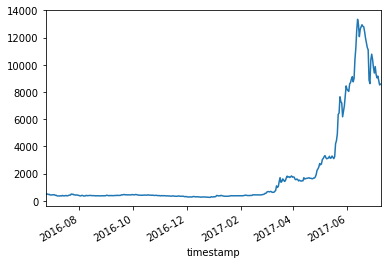

In [58]:
series.plot()
pyplot.show()

### Preparing data

In [48]:
# split data into train and test
X = series.values
train, test = X[0:-12], X[-12:]

print(train[-5:])
print(test[:5])

[ 11600.99  11275.99  11110.     8888.     8620.01]
[ 10355.  10787.  10400.   9800.   9399.]


#### Transform series to supervised learning

In [49]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

#### Transform series to stationary

In [6]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [50]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [71]:
# Test difference function
print(series.head())

_test_differenced = difference(series, 1)
print(_test_differenced.head())

# invert transform
_inverted = list()
for i in range(len(_test_differenced)):
    value = inverse_difference(series, _test_differenced[i], len(series)-i)
    _inverted.append(value)
_inverted = Series(_inverted)
print(_inverted.head())

timestamp
2016-06-24    500.00
2016-06-25    499.01
2016-06-26    499.00
2016-06-27    463.02
2016-06-28    480.00
Name: close, dtype: float64
0    -0.99
1    -0.01
2   -35.98
3    16.98
4   -52.64
dtype: float64
0    499.01
1    499.00
2    463.02
3    480.00
4    427.36
dtype: float64


#### Transform series to scale

In [60]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)

    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)

    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)

    return scaler, train_scaled, test_scaled

In [61]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)

    return inverted[0, -1]

In [69]:
# Test scale function
_test_train_data = train.reshape(len(train), 1)
_test_test_data = test.reshape(len(test), 1)
_, _train_scaled, _test_scaled = scale(_test_train_data, _test_test_data)
_train_scaled_series = Series(_train_scaled[:, 0])
_test_scaled_series = Series(_test_scaled[:, 0])
print(_train_scaled_series.head())
print(_test_scaled_series.head())

0   -0.962281
1   -0.962433
2   -0.962434
3   -0.967929
4   -0.965336
dtype: float64
0    0.542643
1    0.608613
2    0.549515
3    0.457891
4    0.396656
dtype: float64


### LSTM Modeling

In [55]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

### Prediction

In [104]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

### Execution starts here

#### Loading data

In [109]:
series = read_csv('eth_data.csv',
                  header=0,
                  index_col='timestamp',
                  usecols=['timestamp', 'close'],
                  squeeze=True,
                  parse_dates=['timestamp'],
                  date_parser=parser)

print(series.head())

timestamp
2016-06-24    500.00
2016-06-25    499.01
2016-06-26    499.00
2016-06-27    463.02
2016-06-28    480.00
Name: close, dtype: float64


#### Transform data to be stationary

In [110]:
raw_values = series.values
diff_values = difference(raw_values, 1)

print(raw_values[:5])
print(diff_values[:5])

[ 500.    499.01  499.    463.02  480.  ]
0    -0.99
1    -0.01
2   -35.98
3    16.98
4   -52.64
dtype: float64


#### Transform data to be supervised learning

In [111]:
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

print(supervised.head())
print(supervised_values[:5])

       0      0
0   0.00  -0.99
1  -0.99  -0.01
2  -0.01 -35.98
3 -35.98  16.98
4  16.98 -52.64
[[  0.00000000e+00  -9.90000000e-01]
 [ -9.90000000e-01  -1.00000000e-02]
 [ -1.00000000e-02  -3.59800000e+01]
 [ -3.59800000e+01   1.69800000e+01]
 [  1.69800000e+01  -5.26400000e+01]]


#### Split data into train and test

In [120]:
train, test = supervised_values[0:-45], supervised_values[-45:]

print(train[:5])
print(test[:5])

[[  0.00000000e+00  -9.90000000e-01]
 [ -9.90000000e-01  -1.00000000e-02]
 [ -1.00000000e-02  -3.59800000e+01]
 [ -3.59800000e+01   1.69800000e+01]
 [  1.69800000e+01  -5.26400000e+01]]
[[-4096.     150.01]
 [  150.01  2929.99]
 [ 2929.99   390.  ]
 [  390.     428.99]
 [  428.99   738.01]]


#### Transform the scale of the data

In [121]:
scaler, train_scaled, test_scaled = scale(train, test)

print(scaler)
print(train_scaled[:5])
print(test_scaled[:5])

MinMaxScaler(copy=True, feature_range=(-1, 1))
[[-0.01631827 -0.01654189]
 [-0.01654189 -0.01632053]
 [-0.01632053 -0.02444522]
 [-0.02444522 -0.01248293]
 [-0.01248293 -0.02820829]]
[[-0.94149861  0.0175651 ]
 [ 0.0175651   0.64549059]
 [ 0.64549059  0.07177263]
 [ 0.07177263  0.08057946]
 [ 0.08057946  0.15037907]]


#### Fit the model

In [ ]:
lstm_model = fit_lstm(train_scaled, 1, 1000, 4)

#### Forecast the training dataset

In [123]:
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.09171905],
       [-0.07958676],
       [-0.05999038],
       [-0.0304222 ],
       [-0.0247549 ],
       [ 0.0093246 ],
       [ 0.00837041],
       [ 0.02158089],
       [ 0.02636485],
       [ 0.03976168],
       [ 0.04490091],
       [ 0.06159328],
       [ 0.05448641],
       [ 0.07353188],
       [ 0.06285681],
       [ 0.06736441],
       [ 0.06804861],
       [ 0.06657948],
       [ 0.07395269],
       [ 0.0612234 ],
       [ 0.08185585],
       [ 0.07161005],
       [ 0.07477708],
       [ 0.06700708],
       [ 0.08251615],
       [ 0.07423498],
       [ 0.06795307],
       [ 0.07112099],
       [ 0.07513304],
       [ 0.05528422],
       [ 0.08524139],
       [ 0.06753601],
       [ 0.09034748],
       [ 0.07458557],
       [ 0.08343567],
       [ 0.07411309],
       [ 0.07936473],
       [ 0.08199729],
       [ 0.07877435],
       [ 0.0842355 ],
       [ 0.0747325 ],
       [ 0.06810077],
       [ 0.07905526],
       [ 0.08277066],
       [ 0.07387085],
       [ 0

#### Walk-forward validation on the test data

In [125]:
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

day=1, Predicted=6927.237982, Expected=3250.010000
day=2, Predicted=3372.769922, Expected=6180.000000
day=3, Predicted=3752.647055, Expected=6570.000000
day=4, Predicted=6616.379648, Expected=6998.990000
day=5, Predicted=6453.790511, Expected=7737.000000
day=6, Predicted=7055.969596, Expected=8450.970000
day=7, Predicted=7835.112042, Expected=8200.000000
day=8, Predicted=8778.284371, Expected=8110.000000
day=9, Predicted=8522.191197, Expected=8050.000000
day=10, Predicted=8592.409951, Expected=8605.000000
day=11, Predicted=8474.151478, Expected=8699.900000
day=12, Predicted=9154.280502, Expected=8970.000000
day=13, Predicted=9116.064078, Expected=9130.000000
day=14, Predicted=9470.481676, Expected=8751.000000
day=15, Predicted=9642.595334, Expected=9005.000000
day=16, Predicted=9187.309915, Expected=10398.000000
day=17, Predicted=9371.602488, Expected=11240.000000
day=18, Predicted=10818.395503, Expected=12522.000000
day=19, Predicted=11326.139445, Expected=13350.000000
day=20, Predict

#### Report performance

In [127]:
rmse = sqrt(mean_squared_error(raw_values[-45:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1391.496


#### Plot the graph

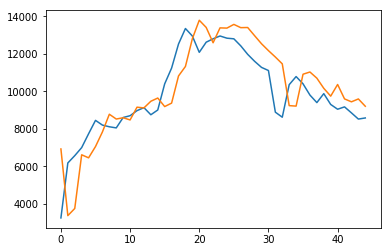

In [129]:
pyplot.plot(raw_values[-45:])
pyplot.plot(predictions)
pyplot.show()